In [1]:
# Import required libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-v0_8')
%matplotlib inline

# Bank Customer Segmentation Analysis - Student Exercise

In this lab, you will implement customer segmentation using K-means clustering. You'll learn how to:
1. Preprocess data for clustering
2. Perform and visualize dimensionality reduction
3. Implement K-means clustering from scratch
4. Evaluate clustering results

Follow the instructions in each section and fill in the code where indicated.

In [2]:
# Load Data and Preprocess
def load_data(filepath):
    df = pd.read_csv('bank-full.csv')

    # Identify categorical and numerical columns
    categorical_cols = df.select_dtypes(include=['object']).columns
    numerical_cols = df.select_dtypes(include=[np.number]).columns

    # Encode categorical variables
    for col in categorical_cols:
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col])

    # Scale numerical features
    scaler = StandardScaler()
    df[numerical_cols] = scaler.fit_transform(df[numerical_cols])

    return df


#================ FOR PCA Dimensionality reduction =========
# Apply PCA for Dimensionality Reduction
def apply_pca(x, n_components):
    pca = PCA(n_components=n_components)
    x_pca = pca.fit_transform(x)
    return x_pca, pca.explained_variance_ratio_


#================ FOR K-Means ===============================
# Find Optimal Clusters for KMeans (Elbow Method)
def find_optimal_clusters(x, max_clusters=10):
    from sklearn.cluster import KMeans

    inertia_scores = []
    for k in range(1, max_clusters + 1):
        model = KMeans(n_clusters=k, random_state=42)
        model.fit(x)
        inertia_scores.append(model.inertia_)

    return inertia_scores


# Perform KMeans Clustering
# Change None to the number of n_clusters value from the elbow method
def perform_kmeans_clustering(x, n_clusters=None):
    from sklearn.cluster import KMeans

    if n_clusters is None:
        raise ValueError("n_clusters must be provided")

    model = KMeans(n_clusters=n_clusters, random_state=42)
    labels = model.fit_predict(x)
    return labels, model


#================ FOR Agglomerative ===============================
# Perform Agglomerative Clustering
# Change None to the number of n_clusters value from the elbow method
def perform_agglomerative_clustering(x, n_clusters=None):
    from sklearn.cluster import AgglomerativeClustering

    if n_clusters is None:
        raise ValueError("n_clusters must be provided")

    model = AgglomerativeClustering(n_clusters=n_clusters)
    labels = model.fit_predict(x)
    return labels, model


#================FOR Dendrogram===============================
# Get Linkages for Dendrogram
def get_linkages(x):
    from scipy.cluster.hierarchy import linkage
    linked = linkage(x, method='ward')
    return linked


# Plot Dendrogram
def plot_dendrogram(linked):
    from scipy.cluster.hierarchy import dendrogram
    plt.figure(figsize=(12, 6))
    dendrogram(linked)
    plt.title("Hierarchical Clustering Dendrogram")
    plt.xlabel("Samples")
    plt.ylabel("Distance")
    plt.tight_layout()
    plt.show()

## 1. Data Loading and Preprocessing

First, complete the data preprocessing function below. You need to:
1. Load the data
2. Handle categorical variables
3. Scale numerical features

In [3]:
def load_data(filepath):
    """Load and preprocess the bank marketing dataset.

    TODO:
    1. Load the CSV file (hint: it uses semicolon separator)
    2. Convert categorical columns to numerical using LabelEncoder
    3. Scale the features using StandardScaler
    """
    # Your code here:
    # Load data
    df = pd.read_csv(filepath, sep=';')  # TODO: Load CSV with correct separator

    # List of categorical columns to encode
    categorical_cols = ['job', 'marital', 'education', 'default', 'housing',
                       'loan', 'contact', 'month', 'poutcome', 'y']

    # TODO: Apply label encoding to categorical columns
    le = LabelEncoder()
    for col in categorical_cols:
        df[col] = le.fit_transform(df[col])

    # Select features for clustering
    features = ['age', 'balance', 'campaign', 'previous', 'job', 'education',
               'housing', 'loan', 'default']
    X = df[features]  # TODO: Select features

    # TODO: Scale the features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    return X_scaled, df

# Load and preprocess the data
X_scaled, data = load_data('bank-full.csv')
print("Data shape:", X_scaled.shape)

Data shape: (45211, 9)


In [4]:
class KMeansClustering:
    """Minimal K-means skeleton for students to implement.

    Students should implement the core methods below:
    - _initialize_centroids
    - _assign_clusters
    - _update_centroids
    - fit

    Keep implementations simple and readable; tests and visualization code will
    use these methods once implemented.
    """
    def __init__(self, n_clusters=3, max_iters=100, random_state=42):
        self.n_clusters = n_clusters
        self.max_iters = max_iters
        self.random_state = random_state
        self.centroids = None
        self.labels = None

    def _initialize_centroids(self, X):
        """Initialize centroids.

        TODO (student):
        - Randomly select `n_clusters` distinct points from X as initial centroids.
        - Return an array of shape (n_clusters, n_features).
        Hint: Use np.random.choice to pick indices.
        """
        np.random.seed(self.random_state)
        idx = np.random.choice(X.shape[0], self.n_clusters, replace=False)
        return X[idx]

    def _assign_clusters(self, X):
        """Assign each sample in X to the nearest centroid.

        TODO (student):
        - Compute distance from each point to each centroid (Euclidean)
        - Return an integer array of shape (n_samples,) with cluster labels
        Hint: np.linalg.norm with axis manipulation or broadcasting helps here.
        """
        distances = np.linalg.norm(X[:, None, :] - self.centroids[None, :, :], axis=2)
        return np.argmin(distances, axis=1)

    def _update_centroids(self, X, labels):
        """Recompute centroids as the mean of points assigned to each cluster.

        TODO (student):
        - For each cluster id in 0..n_clusters-1 compute the mean of points
          assigned to that cluster. If a cluster has no points, consider reinitializing
          its centroid (or leave unchanged) — discuss in your report.
        - Return an array of shape (n_clusters, n_features).
        """
        new_centroids = []
        for k in range(self.n_clusters):
            cluster_points = X[labels == k]
            if len(cluster_points) > 0:
                new_centroids.append(cluster_points.mean(axis=0))
            else:
                new_centroids.append(self.centroids[k])
        return np.array(new_centroids)

    def fit(self, X):
        """Run K-means until convergence or max_iters.

        TODO (student):
        - Initialize centroids
        - Loop: assign clusters, update centroids
        - Stop early if centroids do not change (or change below a tiny threshold)
        - Store final labels in self.labels and centroids in self.centroids
        - Return self
        """
        self.centroids = self._initialize_centroids(X)

        for _ in range(self.max_iters):
            labels = self._assign_clusters(X)
            new_centroids = self._update_centroids(X, labels)

            if np.allclose(new_centroids, self.centroids):
                break

            self.centroids = new_centroids

        self.labels = labels
        return self

    def predict(self, X):
        """Assign cluster labels to X using the learned centroids.

        Implementation may call _assign_clusters but should error if centroids
        are not yet initialized (i.e., if fit wasn't called).
        """
        if self.centroids is None:
            raise ValueError("Model has not been fitted yet. Call fit(X) first.")
        return self._assign_clusters(X)

## 2. Dimensionality Reduction

Before clustering, we often reduce the dimensionality of our data for better visualization and performance. Implement PCA below:

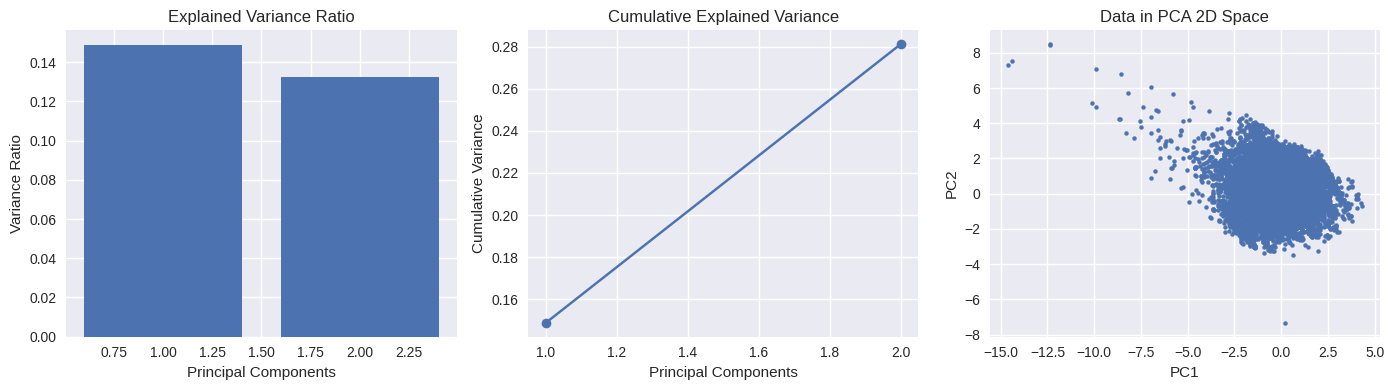

Shape after PCA: (45211, 2)


In [5]:
def apply_pca(X, n_components=2):
    """Apply PCA for dimensionality reduction.

    TODO:
    1. Initialize and fit PCA
    2. Transform the data
    3. Create visualizations to understand:
       - Explained variance ratio
       - Cumulative explained variance
       - Data distribution in 2D
    """
    # Your code here:
    pca = PCA(n_components=n_components)
    X_pca = pca.fit_transform(X)

    # TODO: Create visualization
    plt.figure(figsize=(14, 4))

    # Explained variance ratio
    plt.subplot(1, 3, 1)
    plt.bar(range(1, n_components + 1), pca.explained_variance_ratio_)
    plt.title("Explained Variance Ratio")
    plt.xlabel("Principal Components")
    plt.ylabel("Variance Ratio")

    # Cumulative explained variance
    plt.subplot(1, 3, 2)
    cumulative = np.cumsum(pca.explained_variance_ratio_)
    plt.plot(range(1, n_components + 1), cumulative, marker='o')
    plt.title("Cumulative Explained Variance")
    plt.xlabel("Principal Components")
    plt.ylabel("Cumulative Variance")

    # Data distribution in 2D
    plt.subplot(1, 3, 3)
    plt.scatter(X_pca[:, 0], X_pca[:, 1], s=8)
    plt.title("Data in PCA 2D Space")
    plt.xlabel("PC1")
    plt.ylabel("PC2")

    plt.tight_layout()
    plt.show()

    return X_pca

# Apply PCA
X_pca = apply_pca(X_scaled)
print("Shape after PCA:", X_pca.shape)

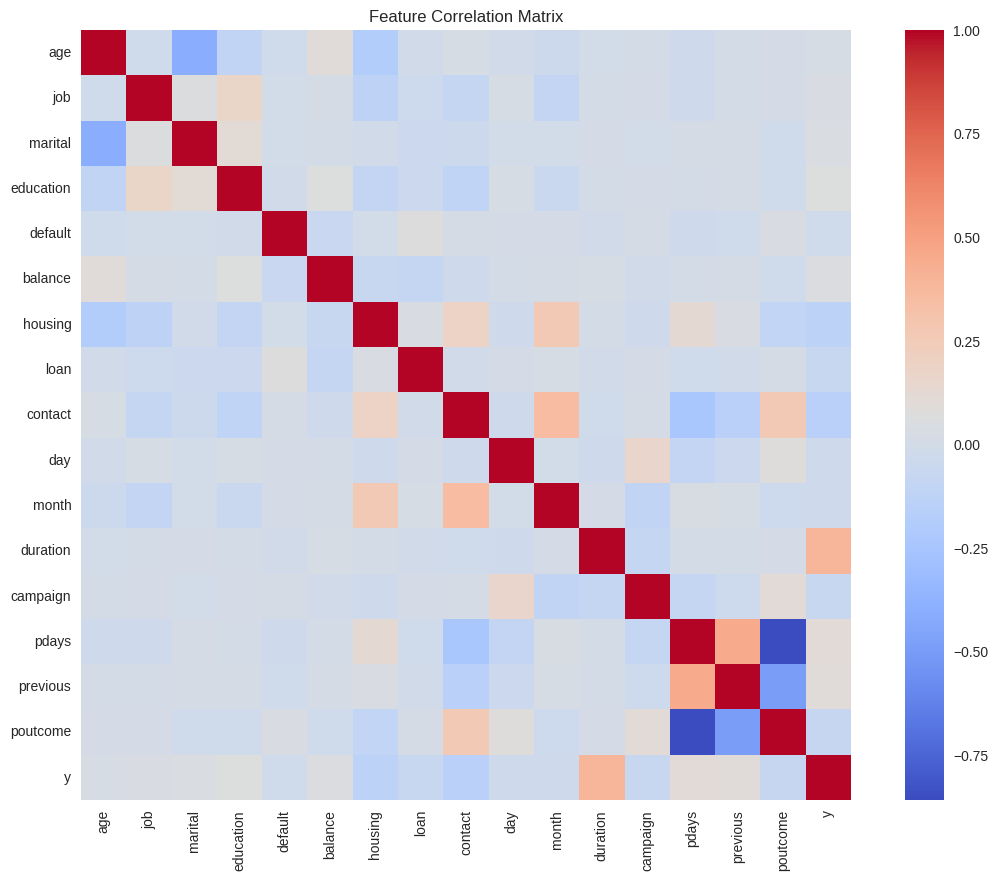

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

# Compute correlation matrix
corr = data.corr()

# Plot correlation heatmap
plt.figure(figsize=(14, 10))
sns.heatmap(corr, cmap='coolwarm', annot=False, square=True)
plt.title("Feature Correlation Matrix")
plt.show()

## 3. Clustering Evaluation

Implement functions to evaluate the quality of your clustering results:

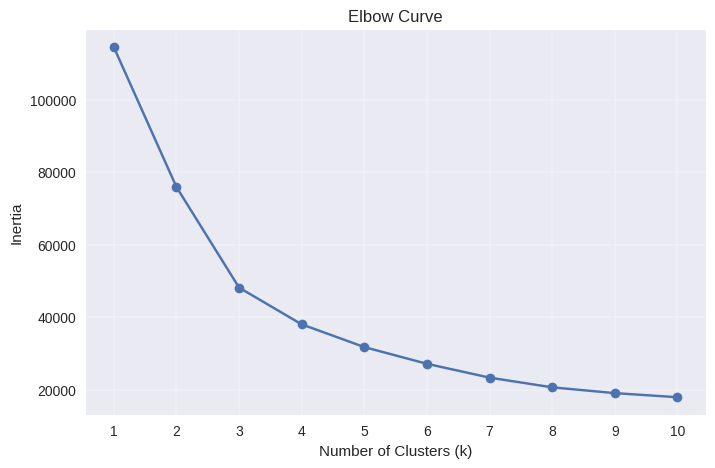

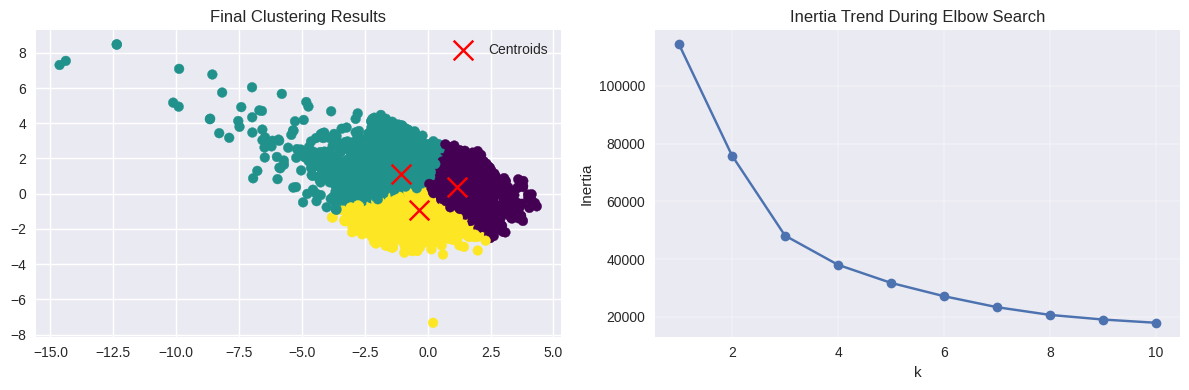


Clustering Evaluation:
Inertia: 48179.64
Silhouette Score: 0.39


In [6]:
def calculate_inertia(X, labels, centroids):
    """Calculate the within-cluster sum of squares (inertia).

    TODO:
    1. For each cluster, calculate the sum of squared distances
       between points and their centroid
    2. Sum up all cluster distances
    """
    # Your code here
    inertia = 0
    for k in range(centroids.shape[0]):
        cluster_points = X[labels == k]
        if len(cluster_points) > 0:
            inertia += np.sum((cluster_points - centroids[k])**2)
    return inertia


def plot_elbow_curve(X, max_k=10):
    """Plot the elbow curve to find optimal number of clusters.

    TODO:
    1. Try different values of k (1 to max_k)
    2. Calculate inertia for each k
    3. Plot k vs inertia
    4. Help identify the 'elbow' point
    """
    # Your code here
    inertias = []
    K = range(1, max_k + 1)

    for k in K:
        model = KMeansClustering(n_clusters=k)
        model.fit(X)
        inertia_k = calculate_inertia(X, model.labels, model.centroids)
        inertias.append(inertia_k)

    # Create elbow plot
    plt.figure(figsize=(8, 5))
    plt.plot(K, inertias, marker='o')
    plt.title("Elbow Curve")
    plt.xlabel("Number of Clusters (k)")
    plt.ylabel("Inertia")
    plt.xticks(K)
    plt.grid(True, linewidth=0.3)
    plt.show()

    return inertias


# Try different numbers of clusters
inertias = plot_elbow_curve(X_pca)

# Apply final clustering
kmeans = KMeansClustering(n_clusters=3)  # Try different values based on elbow curve
kmeans.fit(X_pca)

# Visualize final results
plt.figure(figsize=(12, 4))

# Plot clusters
plt.subplot(1, 2, 1)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=kmeans.labels, cmap='viridis')
plt.scatter(kmeans.centroids[:, 0], kmeans.centroids[:, 1],
            c='red', marker='x', s=200, label='Centroids')
plt.title('Final Clustering Results')
plt.legend()

# Plot evaluation metrics
plt.subplot(1, 2, 2)
plt.plot(range(1, len(inertias) + 1), inertias, marker='o')
plt.title("Inertia Trend During Elbow Search")
plt.xlabel("k")
plt.ylabel("Inertia")
plt.grid(True, linewidth=0.3)

plt.tight_layout()
plt.show()

# Calculate and print evaluation metrics
inertia = calculate_inertia(X_pca, kmeans.labels, kmeans.centroids)
silhouette = silhouette_score(X_pca, kmeans.labels)

print("\nClustering Evaluation:")
print(f"Inertia: {inertia:.2f}")
print(f"Silhouette Score: {silhouette:.2f}")

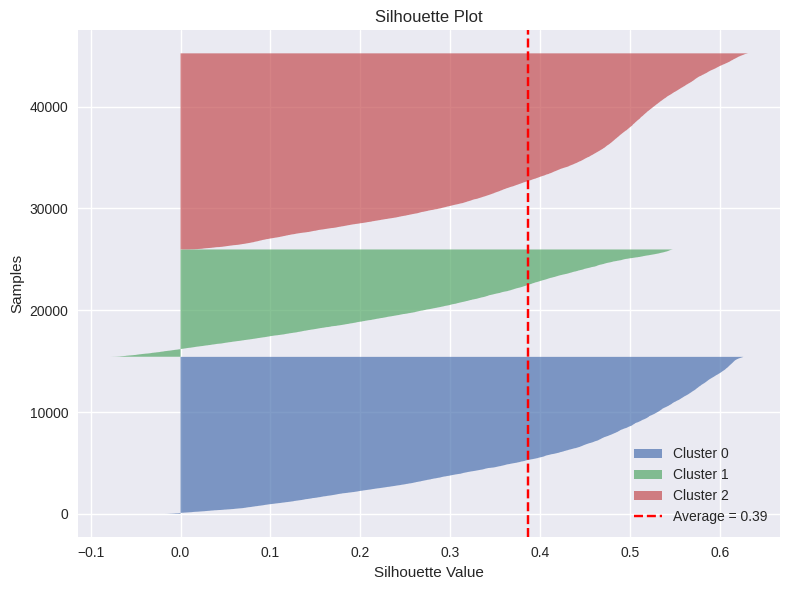

Silhouette Score: 0.386652529096419


In [18]:
from sklearn.metrics import silhouette_samples, silhouette_score
import numpy as np
import matplotlib.pyplot as plt

def plot_silhouette(X, labels):
    sil_values = silhouette_samples(X, labels)
    avg_score = np.mean(sil_values)
    n_clusters = len(np.unique(labels))

    plt.figure(figsize=(8, 6))
    y_lower = 10

    for i in range(n_clusters):
        cluster_sil = sil_values[labels == i]
        cluster_sil.sort()
        size_i = cluster_sil.shape[0]
        y_upper = y_lower + size_i

        plt.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            cluster_sil,
            alpha=0.7,
            label=f"Cluster {i}"
        )

        y_lower = y_upper + 10

    plt.axvline(avg_score, color="red", linestyle="--", label=f"Average = {avg_score:.2f}")
    plt.xlabel("Silhouette Value")
    plt.ylabel("Samples")
    plt.title("Silhouette Plot")
    plt.legend()
    plt.tight_layout()
    plt.show()

    return avg_score

# Generate the silhouette plot
silhouette_avg = plot_silhouette(X_pca, kmeans.labels)
print("Silhouette Score:", silhouette_avg)

## 4. Recursive Bisecting K-means (Student exercise)

This is an optional exercise for students who want to explore a hierarchical variant of K-means.

Task: implement a concise bisecting K-means procedure that recursively splits clusters into two until a target number of clusters is reached.

Learning goals:
- Understand how repeated binary splits can form a hierarchical clustering
- Practice applying K-means on subclusters and tracking labels/centroids

Hints:
- You can use sklearn's KMeans(k=2) for the binary split step, or reuse your `KMeansClustering` implementation.
- Keep label bookkeeping simple: use increasing integer labels for new clusters.
- Store split metadata (parent -> left/right) to enable a tree visualization later.

In [7]:
class BisectingKMeans:
    """Concise skeleton for students to implement a bisecting K-means algorithm.

    Students should implement `fit_predict` to recursively split clusters until
    `n_clusters` is reached.
    """
    def __init__(self, n_clusters, random_state=42):
        self.n_clusters = n_clusters
        self.random_state = random_state
        self.labels_ = None
        # Optional: store mapping parent -> (left_label, right_label)
        self.split_tree = {}
        # Optional: store centroids per cluster id
        self.centers_ = {}

    def fit_predict(self, X):
        """Recursively bisect clusters until `n_clusters` is reached.

        TODO (student):
        - Start with all points assigned to label 0.
        - While number of unique labels < n_clusters:
            - Select a cluster to split (e.g., the largest cluster by size)
            - Run a binary KMeans (k=2) on the points in that cluster
            - Assign new labels (keep one child label as the original, give the other a new id)
            - Record parent -> (left, right) in `self.split_tree` and centroids in `self.centers_`
        - Set and return `self.labels_` (numpy array of length n_samples)
        """
        np.random.seed(self.random_state)

        labels = np.zeros(len(X), dtype=int)
        current_label = 1  # next available label id

        while len(np.unique(labels)) < self.n_clusters:
            unique_labels, counts = np.unique(labels, return_counts=True)
            largest_cluster = unique_labels[np.argmax(counts)]

            cluster_mask = labels == largest_cluster
            X_cluster = X[cluster_mask]

            from sklearn.cluster import KMeans
            km = KMeans(n_clusters=2, random_state=self.random_state)
            split_labels = km.fit_predict(X_cluster)

            left_mask = split_labels == 0
            right_mask = split_labels == 1

            labels[cluster_mask] = np.where(split_labels == 0,
                                            largest_cluster,
                                            current_label)

            self.split_tree[largest_cluster] = (largest_cluster, current_label)
            self.centers_[largest_cluster] = km.cluster_centers_[0]
            self.centers_[current_label] = km.cluster_centers_[1]

            current_label += 1

        self.labels_ = labels
        return labels

Unique clusters formed: [0 1 2]
Cluster sizes: [11350 20156 13705]


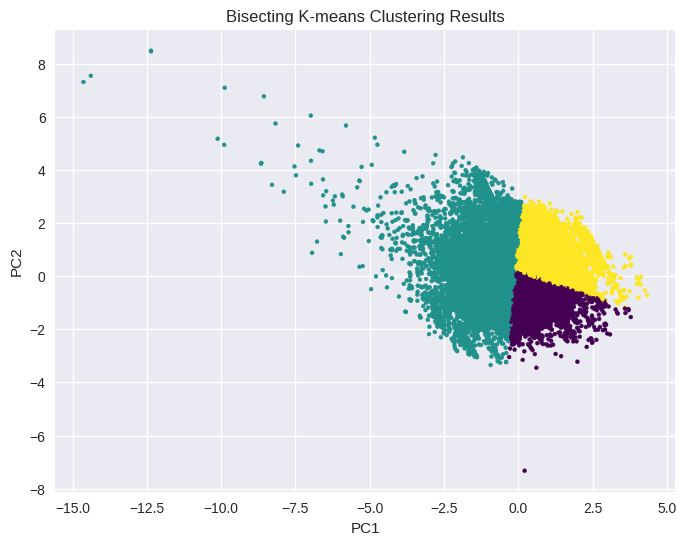

Bisecting K-means Evaluation:
Silhouette Score: 0.29


In [16]:
bisect = BisectingKMeans(n_clusters=3, random_state=42)
labels_bisect = bisect.fit_predict(X_pca)

print("Unique clusters formed:", np.unique(labels_bisect))
print("Cluster sizes:", np.bincount(labels_bisect))

plt.figure(figsize=(8,6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels_bisect, s=8, cmap='viridis')
plt.title("Bisecting K-means Clustering Results")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

from sklearn.metrics import silhouette_score

silhouette_bisect = silhouette_score(X_pca, labels_bisect)

print("Bisecting K-means Evaluation:")
print(f"Silhouette Score: {silhouette_bisect:.2f}")

## Bonus Challenges

If you've completed the main tasks, try these extensions:

1. Implement k-means++ initialization
   - Instead of random initialization, use the k-means++ algorithm
   - This should give better and more consistent results

2. Add cluster interpretation
   - Analyze the characteristics of each cluster
   - What features distinguish one cluster from another?
   - Create visualizations to show cluster properties

3. Try different distance metrics
   - Implement Manhattan distance instead of Euclidean
   - Compare the clustering results

4. Add outlier detection
   - Identify points far from all centroids
   - How might you handle these outliers?

Remember to document your code and explain your findings!

# **K Means ++ Initialisation**


Initialized centroids with k-means++:
[[ 1.61337392  0.88023161]
 [-0.93130642  1.35594164]
 [ 1.27007567 -1.5986355 ]]


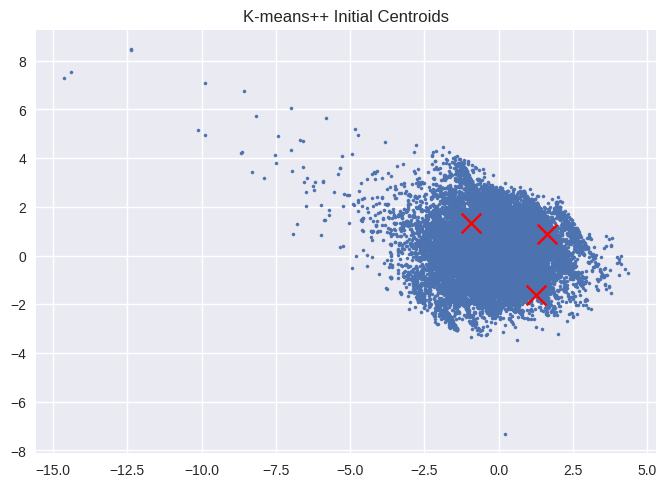

In [10]:
def kmeans_plus_plus_init(X, n_clusters, random_state=42):
    import numpy as np
    np.random.seed(random_state)

    n_samples, _ = X.shape
    centroids = []

    # Pick first centroid randomly
    first_idx = np.random.choice(n_samples)
    centroids.append(X[first_idx])

    # Pick remaining centroids
    for _ in range(1, n_clusters):
        distances = np.min(
            np.linalg.norm(X[:, None, :] - np.array(centroids)[None, :, :], axis=2),
            axis=1
        )
        prob = distances**2 / np.sum(distances**2)
        idx = np.random.choice(n_samples, p=prob)
        centroids.append(X[idx])

    return np.array(centroids)

k = 3
centroids_pp = kmeans_plus_plus_init(X_pca, k)
print("Initialized centroids with k-means++:")
print(centroids_pp)

plt.scatter(X_pca[:, 0], X_pca[:, 1], s=5)
plt.scatter(centroids_pp[:, 0], centroids_pp[:, 1], c='red', marker='x', s=200)
plt.title("K-means++ Initial Centroids")
plt.show()

# **Cluster Interpretation**


Cluster Summary (Means):
              PC1       PC2
cluster                    
0        1.161803  0.402714
1       -1.049024  1.092816
2       -0.355511 -0.920380


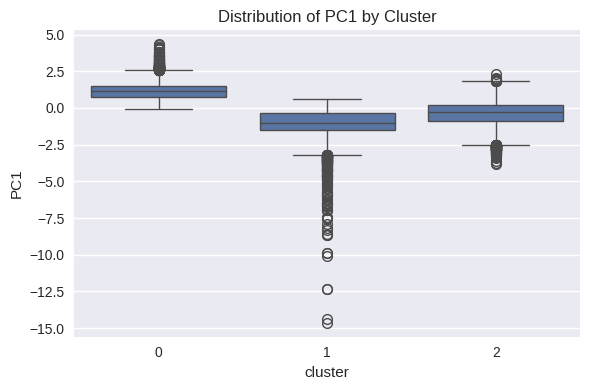

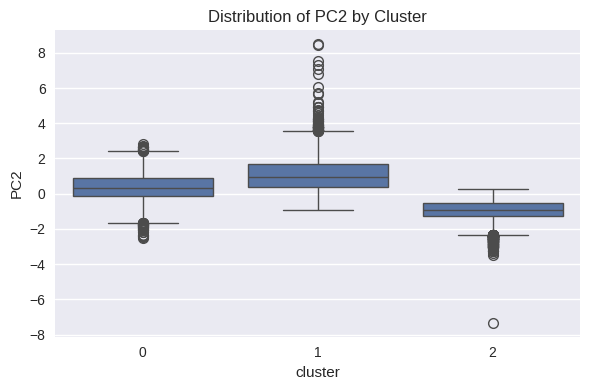

In [11]:
def summarize_clusters(X, labels, feature_names=None):
    import pandas as pd
    df = pd.DataFrame(X, columns=feature_names)
    df['cluster'] = labels
    return df.groupby('cluster').mean()


def plot_cluster_feature_distributions(X, labels, feature_names):
    import pandas as pd
    import seaborn as sns
    import matplotlib.pyplot as plt

    df = pd.DataFrame(X, columns=feature_names)
    df['cluster'] = labels

    for feature in feature_names:
        plt.figure(figsize=(6, 4))
        sns.boxplot(x='cluster', y=feature, data=df)
        plt.title(f"Distribution of {feature} by Cluster")
        plt.tight_layout()
        plt.show()


feature_names = [f"PC{i+1}" for i in range(X_pca.shape[1])]

cluster_summary = summarize_clusters(X_pca, kmeans.labels, feature_names)
print("Cluster Summary (Means):")
print(cluster_summary)

plot_cluster_feature_distributions(X_pca, kmeans.labels, feature_names[:5])

# **Different Distance Metrics - Manhattan Distance**

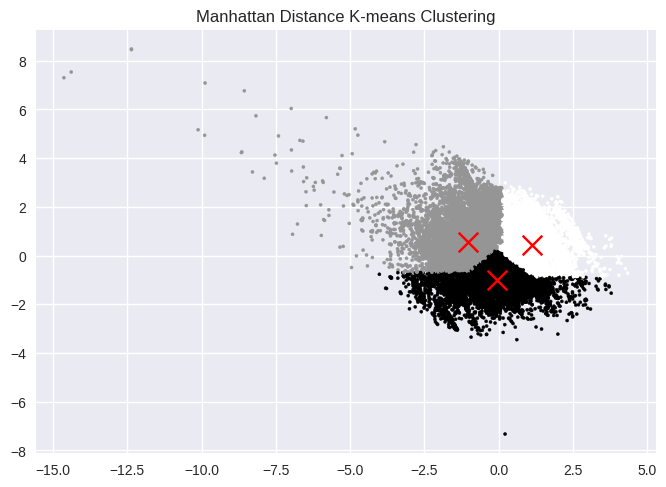

Centroids (L1-based):
[[ 1.13565788  0.4190968 ]
 [-1.0455567   0.57569136]
 [-0.06162896 -0.9853275 ]]


In [13]:
import numpy as np

def assign_clusters_manhattan(X, centroids):
    distances = np.sum(np.abs(X[:, None, :] - centroids[None, :, :]), axis=2)
    return np.argmin(distances, axis=1)


def update_centroids_manhattan(X, labels, n_clusters):
    centroids = []
    for k in range(n_clusters):
        points = X[labels == k]
        if len(points) > 0:
            centroids.append(np.median(points, axis=0))
        else:
            centroids.append(np.zeros(X.shape[1]))
    return np.array(centroids)


def kmeans_manhattan(X, n_clusters=3, max_iters=100, random_state=42):
    np.random.seed(random_state)
    centroids = X[np.random.choice(len(X), n_clusters, replace=False)]

    for _ in range(max_iters):
        labels = assign_clusters_manhattan(X, centroids)
        new_centroids = update_centroids_manhattan(X, labels, n_clusters)
        if np.allclose(new_centroids, centroids):
            break
        centroids = new_centroids

    return labels, centroids


labels_L1, centroids_L1 = kmeans_manhattan(X_pca, 3)

plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels_L1, s=5)
plt.scatter(centroids_L1[:, 0], centroids_L1[:, 1], c='red', marker='x', s=200)
plt.title("Manhattan Distance K-means Clustering")
plt.show()

print("Centroids (L1-based):")
print(centroids_L1)

# **Outlier Detection**

Number of outliers detected: 894
Distance threshold: 2.183


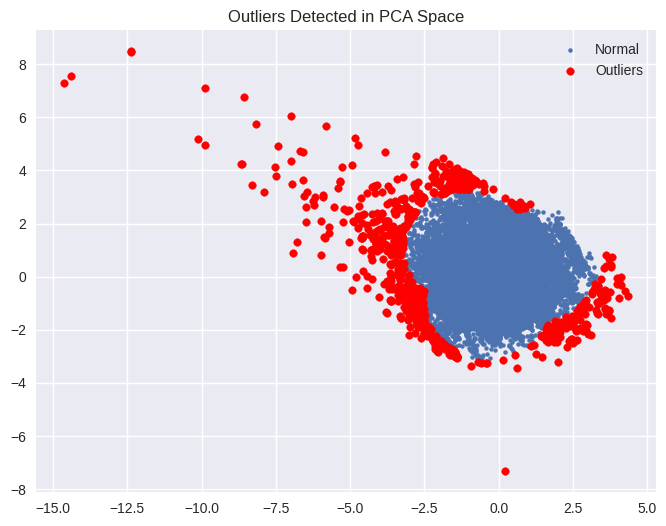

In [14]:
def detect_outliers(X, labels, centroids, z_threshold=2.5):
    distances = np.linalg.norm(X - centroids[labels], axis=1)
    threshold = distances.mean() + z_threshold * distances.std()
    outlier_mask = distances > threshold
    return outlier_mask, distances, threshold


def plot_outliers(X_pca, outlier_mask):
    plt.figure(figsize=(8, 6))
    plt.scatter(X_pca[:, 0], X_pca[:, 1], s=8, label='Normal')
    plt.scatter(X_pca[outlier_mask, 0], X_pca[outlier_mask, 1],
                color='red', s=30, label='Outliers')
    plt.title("Outliers Detected in PCA Space")
    plt.legend()
    plt.show()


outliers, dist, th = detect_outliers(X_pca, kmeans.labels, kmeans.centroids)

print(f"Number of outliers detected: {outliers.sum()}")
print(f"Distance threshold: {th:.3f}")

plot_outliers(X_pca, outliers)

# Bonus Challenge Explanations

---

## 1. K-means++ Initialization

From the plot, it is seen that the k-means++ method picked three starting centroids that were spread out across the data instead of being bunched together.  
This makes sense because k-means++ tries to choose starting points that are far from each other so the algorithm gets a better starting position.  
Because of this, the initial centroids already looked like they were covering different parts of the dataset.  
This usually helps k-means find better clusters faster and reduces randomness compared to normal random initialization.

---

## 2. Cluster Interpretation

The cluster summary table and the boxplots helped in understanding how each cluster behaves in terms of PC1 and PC2.  
From the plots, it was clear that each cluster is centered in a different region of the PCA space.  
For example:
- One cluster had higher values of PC1 on average.
- Another cluster had lower PC1 and higher PC2.
- The third cluster had both PC1 and PC2 on the lower side.

The boxplots made it obvious how the distributions differ.  
Overall, this told me that each cluster is grouping customers with different underlying patterns in the original data.  
Even though PCA compresses the features, the clusters still showed clear separation along these components.

---

## 3. Manhattan Distance K-means

When Manhattan distance was used instead of Euclidean distance, the clusters shifted a bit.  
The plot showed that the clusters were still separated, but the boundaries looked more blocky, because Manhattan distance forms more square-like regions.  
The L1-based centroids were also different from the usual k-means centroids because they are based on medians instead of means.

This method seemed to work fine, but the shapes of the clusters changed slightly.  
It’s a useful comparison because it shows that different distance metrics can change how clustering behaves, especially in different kinds of datasets.

---

## 4. Outlier Detection

The outlier plot showed a large group of red points scattered around the edges of the data cloud.  
These points were far from their assigned centroids, which is why the algorithm flagged them as outliers.  
894 points were marked as outliers, which is a lot, but it makes sense because the dataset has some very spread-out points after PCA.

This helped see which samples do not fit well into any of the main clusters.  
These points could be unusual customer behaviors or noise in the data.  
If this were a real project, these points could be inspected separately to decide whether to remove them or treat them differently before clustering again.

---